In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (4.0, 2.)
pylab.rcParams['lines.linewidth'] = 1.0
pylab.rcParams['font.size'] = 12.0
pylab.rcParams['axes.linewidth'] = 1
pylab.rcParams['axes.titlesize'] = '14' 
pylab.rcParams['axes.labelsize'] = '10'
pylab.rcParams['axes.linewidth'] = 1
pylab.rcParams['figure.subplot.wspace'] = 0.5

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
import itertools
from scipy import linalg
import matplotlib as mpl
import h5py

from detect import detectData


Populating the interactive namespace from numpy and matplotlib


In [2]:
import socket
if socket.gethostname() == 'dialga':
    data_path = '/data/MEA/neuropixel/rawDataSample.bin'
else:
    data_path = '/home/cole/rawDataSample.bin'
# data = h5py.File(data_path, 'r')
data = np.fromfile(data_path, dtype=np.int16).reshape((1800000,385))



In [16]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames
num_channels = 385
num_recording_channels = 374
spike_delay = 5
spike_peak_duration = 5
noise_duration = 2
noise_amp = 80000
max_neighbors = 14
to_localize = True
cutout_length = 60
fps = 30000
threshold = 20 #20

detectData(data_path, num_channels, num_recording_channels, spike_delay, \
           spike_peak_duration, noise_duration, noise_amp, max_neighbors,
           to_localize, cutout_length, fps, threshold, maa=0, \
           maxsl=12, minsl=3, ahpthr=0)

# Sampling rate: 30000
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
tInc:100000
Analysing 100000 frames; -42 100055
t0 = 0, t1 = 100000
Analysing 100000 frames; 99958 200055
t0 = 100000, t1 = 200000
Analysing 100000 frames; 199958 300055
t0 = 200000, t1 = 300000
Analysing 100000 frames; 299958 400055
t0 = 300000, t1 = 400000
Analysing 100000 frames; 399958 500055
t0 = 400000, t1 = 500000
Analysing 100000 frames; 499958 600055
t0 = 500000, t1 = 600000
Analysing 100000 frames; 599958 700055
t0 = 600000, t1 = 700000
Analysing 100000 frames; 699958 800055
t0 = 700000, t1 = 800000
Analysing 100000 frames; 799958 900055
t0 = 800000, t1 = 900000
Analysing 100000 frames; 899958 1000055
t0 = 900000, t1 = 1000000
Analysing 100000 frames; 999958 1100055
t0 = 1000000, t1 = 1100000
Analysing 100000 frames; 1099958 1200055
t0 = 1100000, t1 = 1200000
Analysing 100000 frames; 1199958 1300055
t0 = 12000

In [17]:
sp = np.loadtxt('ProcessedSpikes')

In [18]:
f = open('neighbormatrix','r')
neighs = []
for l in f.readlines():
    neighs.append(np.array(l[:-2].split(',')).astype(int))
f.close()
f = open('positions','r')
pos = []
for l in f.readlines():
    pos.append(np.array(l[:-2].split(',')).astype(int))
f.close()

<IPython.core.display.Javascript object>


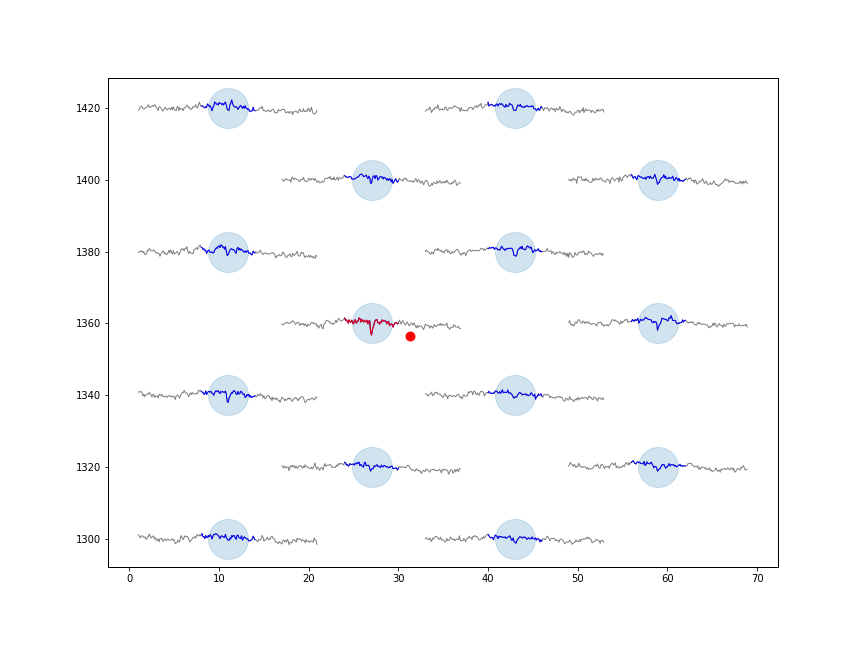

(132, 14229, 146501.0, 31.272400000000001, 1356.3900000000001)


In [19]:
plt.figure(figsize=(12,9))
for i in (1000,):
    ch = int(sp[i,0])
    t = int(sp[i,1])
    a = sp[i,2]
    x = sp[i,3]
    y = sp[i,4]
    print(ch,t,a,x,y)
    cutlen = sp[0].shape[0]-5
    #plt.plot(sp[i][5:])

    plt.scatter(np.array(pos)[neighs[ch],0],np.array(pos)[neighs[ch],1], s=1600, alpha=0.2)    
    
    t1 = np.max((0,t-100))
    t2 = t+100

    # plt.plot(pos[ch][0]+np.arange(t1,t2)/10., pos[ch][1]+data[t1:t2,ch]/10,'r')
    for n in neighs[ch]:
    #     print(n)
        plt.plot(pos[n][0]+np.arange(t2-t1)/10.-10,pos[n][1]+data[t1:t2,n]/10.,'gray')
        plt.plot(pos[n][0]+(np.arange(cutlen)+t-t1-30)/10.-10,pos[n][1]+data[t-30:t+cutlen-30,n]/10.,'b')
    plt.plot(pos[ch][0]+(np.arange(cutlen)+t-t1-30)/10.-10,pos[ch][1]+sp[i][5:]/10.,'r')
    plt.scatter(x,y,s=80,c='r')
# plt.axis('equal')

<IPython.core.display.Javascript object>


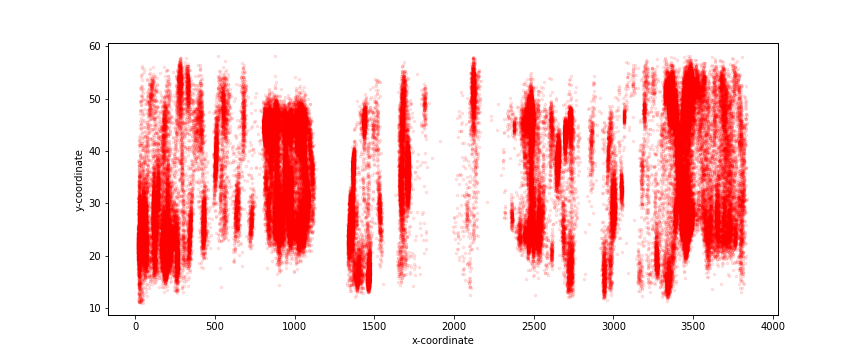

In [20]:
%matplotlib notebook
plt.figure(figsize=(12,5))
plt.plot(sp[:,4], sp[:,3],'r.',ms=5, alpha=0.1)
# plt.axis('equal')
# plt.xlim((775,975))
# plt.ylim((10,60))
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')

In [21]:
cutouts = np.array(sp)[:,5:]
pca = PCA(n_components=2, whiten=True)
cutouts_pca = pca.fit_transform(cutouts)
cutouts_pca.shape

(134537, 2)

In [22]:
sp_pos = np.array(sp)[:,3:5]
fourvec = np.hstack((sp_pos, 40*cutouts_pca))
ms = MeanShift(bandwidth = 20, bin_seeding=True, min_bin_freq=10, n_jobs=-1)
ms.fit(fourvec)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
# print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

('Number of estimated clusters:', 166)


<IPython.core.display.Javascript object>


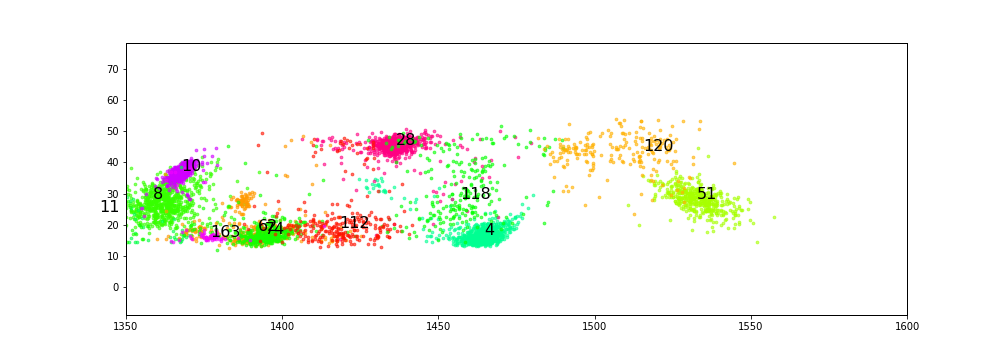

(1350, 1600)

In [24]:
%matplotlib notebook
plt.figure(figsize=(14,5))
# colors = 100*['r', 'g', 'b', 'c', 'k', 'y', 'm']
colors = plt.cm.hsv(1.*np.random.permutation(n_clusters_)/n_clusters_)

for cl in np.unique(labels):
    inds = np.where(labels==cl)[0][:1000]
    plt.scatter(sp_pos[inds,1], sp_pos[inds,0], marker='.', color = colors[cl],s=30, alpha=0.6)
    plt.text(cluster_centers[cl,1], cluster_centers[cl,0], str(cl), color='k', fontsize=16)

# plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker="x", color ='k', s=150, linewidths = 5, zorder=10)
plt.axis('equal')
# plt.xlim((800,875))
plt.xlim((1350,1600))


<IPython.core.display.Javascript object>


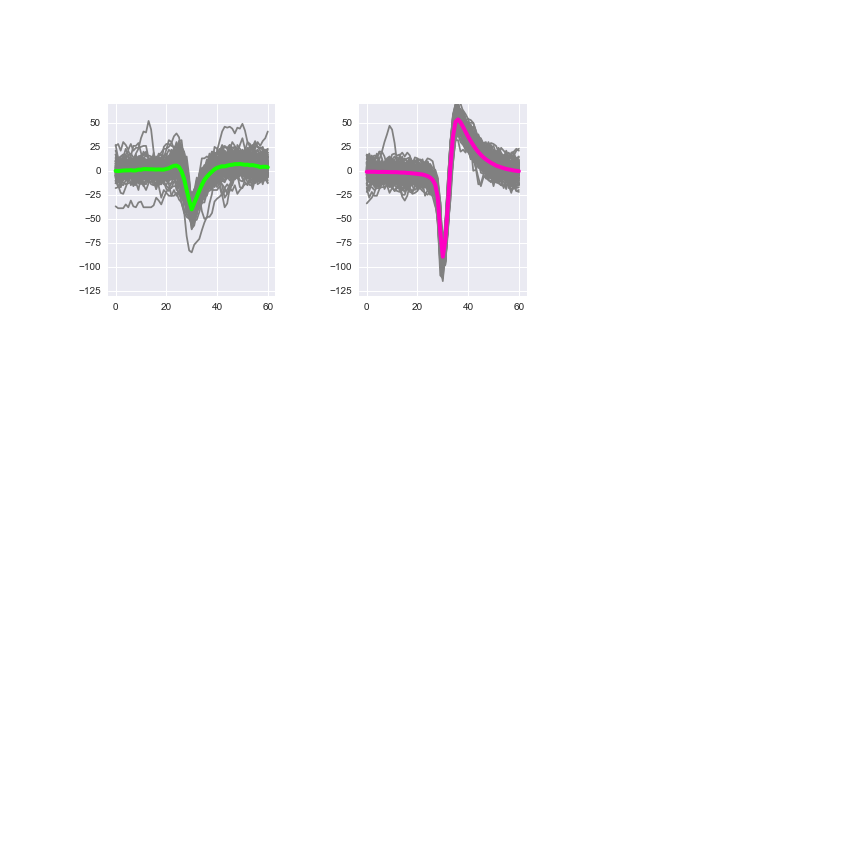

In [62]:
plt.figure(figsize=(12,12))

units = ((121,4))
for i,cl in enumerate(units):
    inds = np.where(labels==cl)[0]
    plt.subplot(3,3,i+1)
    plt.plot(cutouts[inds[:100],:].T,'gray');
    plt.plot(np.mean(cutouts[inds,:],axis=0),c=colors[cl], lw=4);
    plt.ylim((-130,70))